# Analysis of Science Textbooks
by Gabriel Dutra, Peiyu Guo, Kayla Rockhill, Ji Hoon Kim and Minjoon Kouh
2019 - 2020

## Introduction

A complex body of knowledge, such as science, is composed of various concepts and ideas that overlap and interconnect with one another.  For example, in the discipline of physics, the concept of energy is used to explain the motion of an object.  In chemistry, the energy concept is used to explain the release of heat during a chemical reaction.  In biology, energy metabolism is considered to be one of the most important cellular processes of an organism.  Therefore, a role of a teacher is to provide a thoughtful, well-designed curriculum, or a topical trajectory through many pieces of information, and help students to integrate different concepts toward a deep understanding of a topic.  

A science textbook, with its sequence of chapters and sections, is an example of a carefully-designed trajectory through topics.  While such reference sequences developed by subject experts are highly valuable, different topical trajectories can also be worthwhile and perhaps more effective for different teachers or students.  A student may benefit from a different entry point to a topic, based on her/his interest or background knowledge.  For example, introductory physics may be taught in different sequences, based on whether a student is majoring in physics, chemistry, or biology.  Different curricular sequences would highlight different connections between concepts and generate diverse insights about a topic.  

We developed a method for producing topical sequences through a corpus of science textbooks, based on text analysis and path-minimizing heuristic algorithms.  It would be useful for students or teachers of introductory collegiate science courses, where wide-ranging topics are introduced to a group of students whose interests and backgrounds are similarly wide-ranging.  A teacher may use it to develop a lesson plan that explores connections between different topics and disciplines.  A biology student who knows about the membrane potential of a cell from a biology course may benefit from reading about the concept of electrical potential from a physics textbook.  Conversely, a physics student may reinforce the concept of electricity by learning about electrical phenomena from a biology textbook.  

In [1]:
# Do simple bulk file processing tasks here.
# Useful for fixing some errors with filename conventions, etc..

import os
import glob

# This will NOT be used often.
# Only for one-time processing (e.g., batch renaming).
path_to_files = '.\\data\\OS_BIOL\\'
def do_onetime_file_processing(path_to_files):
    i = 0
    for fn in sorted(glob.glob(path_to_files+'*.txt')):
        print('%4d: %s'%(i,fn))
        fn_target = str.replace(fn,'\\OS_ASTR\\OS_ASTRO_','\\OS_ASTR\\OS_ASTR_')
        print('%4d: %s'%(i,fn_target))
        #os.system('mv %s %s'%(fn,fn_target))
        #os.rename(fn,fn_target)
        i=i+1

# Commented out.
#do_onetime_file_processing('.\\data\\OS_BIOL\\')

## Reading data.

We used an open-access science textbook from OpenStax 

PHYS: (https://openstax.org/details/books/college-physics in June, 2018)

CHEM: (https://openstax.org/details/books/chemistry-2e in May, 2019)

BIOL: (https://openstax.org/details/books/biology-2e in May, 2019)

We collected the content of each textbook as a simple textfile.  So no special characters, no mathematical symbols (which could be a limitation of our approach, given the importance of mathematical formalism in physics). The smallest unit of data was the textfile of each section, which we will call a document. The collection of all sections for a given textbook will be called the corpus. 

Following well-established technique of treating each text document as a bag-of-words, we removed uninformative common words (such as 'the' or 'because') and performed word stemming, using Python's NLTK (Natural Language TookKit) module. Stemming allows the subsequent processing to disregard minor variations of the same word, by removing common prefixes and suffixes. For example, after stemming operation, 'force', 'forces', and 'forced' will be all processed as the same term, 'forc'. 

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
# Import and download things for processing text data.
import unicodedata

# Download stop words from nltk module (just do it once).
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

print('Stop words:')
print(stop)

#from nltk.stem.porter import PorterStemmer
#stemmer = PorterStemmer()
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

print('\nExample of stemming')
print(stemmer.stem('forces'))
print(stemmer.stem('forced'))
print(stemmer.stem('force'))

def un_unicode (str):
    # Convert unicode into ascii.
    str = unicodedata.normalize('NFKD',str).encode('ascii','ignore')
    return str

# Make tokens into a string.
def token2str (token):
    str = ''
    for w in token:
        str = str + ' ' + w
    return str.strip()

def clean_txt (txt,stemmer,stop):
    #import re # Use regular expression.
    txt = txt.strip()
    txt = txt.replace('"','')
    txt = txt.replace(',','')
    txt = txt.replace('.','')
    txt = txt.replace(';','')
    txt = txt.replace(':','')
    txt = txt.lower()
    token = txt.split()
    # Remove stop words before stemming.
    token = [w for w in token if w not in stop]
    token = [stemmer.stem(w) for w in token]
    return token2str(token)

# Test clean_txt
assert clean_txt("This name is MJK.",stemmer,stop)=='name mjk'

Stop words:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [4]:
# Helper functions for reading the data files.

# Note: The data files (.txt) correspond to individual section of the
# textbook.  The first line of each file is the section title.
# The text files are named "Chapter.Section.txt".

def sort_list (list1,list2):
    # Sort list1 and list2, based on list1.
    # Example
    #   list1 = list(('1','2','3'))
    #   list2 = list(('c','b','a'))
    idx = np.argsort(list1)
    sorted_list1 = list()
    sorted_list2 = list()
    for i in idx:
        sorted_list1.append(list1[i])
        sorted_list2.append(list2[i])
    return sorted_list1, sorted_list2


def digest_txtfiles (path_to_files):
    contents = list() # content of each files.
    fileNames = list() # filename.
    firstLines = list() # section title (first lines of each file)

    i = 0
    for fn in sorted(glob.glob(path_to_files+'*.txt')):
        #print('%4d: %s'%(i,fn))
        i=i+1

        thisFile = open(fn,'r',encoding = "UTF-8")
        #thisFile = open(fn,'r',encoding = "UTF-8♦")
        #thisFile = open(fn,'r', encoding='utf-8-sig')

        firstLine = thisFile.readline()
        # Remove '\n' at the end and unwanted character at the beg.
        #firstLine = firstLine[1:-1] 
        firstLine = firstLine[:-1] 
        firstLines.append(firstLine)

        txt = thisFile.read()
        txt = clean_txt(txt,stemmer,stop)
        #txt = un_unicode(txt)
        contents.append(txt)
        thisFile.close()

        # Clean up filename.
        fn = fn.replace(path_to_files,'')
        fn = fn.replace('.txt','')
        fileNames.append(fn)

    # Sort the order of docs, based on filenames.
    _, sorted_contents = sort_list(fileNames,contents)
    sorted_fileNames, sorted_firstLines = sort_list(fileNames,firstLines)

    #print ('\nNumber of documents: %d'%len(docs))
    return sorted_contents, sorted_firstLines, sorted_fileNames



In [5]:
# For testing purpose.
# digest textfiles of individual corpus.
filesep = '\\'
OS_PHYS, OS_PHYS_titles, OS_PHYS_fnames = digest_txtfiles('.'+filesep+'data'+filesep+'OS_PHYS'+filesep)
OS_CHEM, OS_CHEM_titles, OS_CHEM_fnames = digest_txtfiles('.'+filesep+'data'+filesep+'OS_CHEM'+filesep)
OS_BIOL, OS_BIOL_titles, OS_BIOL_fnames = digest_txtfiles('.'+filesep+'data'+filesep+'OS_BIOL'+filesep)
#OS_ASTR, OS_ASTR_titles, OS_ASTR_fnames = digest_txtfiles('./data/OS_ASTR/')
#print(*OS_PHYS_titles,sep='\n')

# Quick look at the data.
print ('\n===== A quick look at the data =====\n')
print("\n=== Look at first few lines of texts.")
print (OS_PHYS[0][:100]) 
print("\n=== Look at section titles")
print (OS_PHYS_titles[0:4])
print("\n=== Look at file names")
print (OS_PHYS_fnames[:3]) 


===== A quick look at the data =====


=== Look at first few lines of texts.
galaxi immens atom small yet law physic describ rest nature—an indic under uniti univers law physic 

=== Look at section titles
['\ufeff1.0 Introduction to Science and the Realm of Physics, Physical Quantities, and Units', '\ufeff1.1 Physics: An Introduction', '\ufeff1.2 Physical Quantities and Units', '\ufeff1.3 Accuracy, Precision, and Significant Figures']

=== Look at file names
['OS_PHYS_01.00', 'OS_PHYS_01.01', 'OS_PHYS_01.02']


In [6]:
FLAG_save_data = 1

datafile = 'OS_books.p'

if FLAG_save_data:    
    OS_PHYS, OS_PHYS_titles, OS_PHYS_fnames = digest_txtfiles('./data/OS_PHYS/')
    OS_CHEM, OS_CHEM_titles, OS_CHEM_fnames = digest_txtfiles('./data/OS_CHEM/')
    OS_BIOL, OS_BIOL_titles, OS_BIOL_fnames = digest_txtfiles('./data/OS_BIOL/')
    #OS_ASTR, OS_ASTR_titles, OS_ASTR_fnames = digest_txtfiles('./data/OS_ASTR/')

    OS_PHYS_data = (OS_PHYS,OS_PHYS_titles,OS_PHYS_fnames)
    OS_CHEM_data = (OS_CHEM,OS_CHEM_titles,OS_CHEM_fnames)
    OS_BIOL_data = (OS_BIOL,OS_BIOL_titles,OS_BIOL_fnames)
    #OS_ASTR_data = (OS_ASTR,OS_ASTR_titles,OS_ASTR_fnames)
    
    # Save data for faster access.
    #data = (OS_PHYS_data, OS_CHEM_data, OS_BIOL_data, OS_ASTR_data)
    data = (OS_PHYS_data, OS_CHEM_data, OS_BIOL_data)
    with open(datafile,'wb') as f:
        pickle.dump(data, f)

else:
    # Load data file.
    with open(datafile,'rb') as f:
        data = pickle.load(f)

    OS_PHYS,OS_PHYS_titles,OS_PHYS_fnames = data[0]
    OS_CHEM,OS_CHEM_titles,OS_CHEM_fnames = data[1]
    OS_BIOL,OS_BIOL_titles,OS_BIOL_fnames = data[2]
    #OS_ASTR,OS_ASTR_titles,OS_ASTR_fnames = data[2]

## Finding informative terms

The texts from college-level introductory physics, chemistry, and biology textbooks from OpenStax (OpenStax College) were collected as plain texts, ignoring special characters or mathematical symbols.  Each section of the textbook is referred to as a "document" and is the smallest unit of data.  The collection of these documents is referred to as a "corpus."  The punctuations and a set of common, uninformative words (such as "the", "and", or "a") were removed, and the remaining words were transformed into their rudimentary forms or word stems, by the removal of suffixes like "-s" or "-ing."  For example, after stemming, "force", "forces", and "forced" are transformed into the same lexicon, "forc".  After a series of these preprocessing steps, each document was reduced into a collection of stemmed terms.  These textural operations were performed with Python's Natural Language ToolKit (NLTK) module (Bird, Loper and Klein, 2009).  

Then, the term frequency-inverse document frequency (tf-idf) metric (Robertson and Spärck Jones, 1976) was calculated, based on the frequency of each term within all documents in the corpus, according to the following formula: 

tf-idf(t,d) = tf(t,d) x idf(t) = tf(t,d) x ( log( (1+N)/(1+df(t)) ) + 1 ), 

\begin{equation}
\textrm{tf-idf}(t,d) = tf(t,d) \log \left(\frac{1+N}{1+df(t)} + 1\right),
\end{equation}

where tf(t,d) denotes the number of occurrences of each term (t) in each document (d), df(t) denotes the number of documents containing a particular term (t), and N is the total number of documents.  The addition of 1 within the log function is to avoid division by zero or log of zero operation.  

This metric quantifies the significance or the level of informative-ness of a term within a corpus of documents.  Low tf-idf value indicates that a term is not used often and/or it is a very generic term that appears throughout the entire corpus, so this term is not informative.  High tf-idf value indicates that it is used quite extensively in a certain document but not too often elsewhere within the corpus, so this term is likely an informative keyword for the document.  



Run tfidf analysis for OS: PHYS, CHEM, BIOL
=== Top terms ===================
forc (0.078), energi (0.075), charg (0.047), wave (0.046), field (0.045), magnet (0.044), veloc (0.043), light (0.041), current (0.040), use (0.038), mass (0.038), motion (0.035), ray (0.035), object (0.035), electron (0.034), electr (0.034), two (0.033), direct (0.033), heat (0.033), one (0.033), 
=== Bottom terms ================
exceed (0.002), seven (0.001), watch (0.001), complic (0.001), though (0.001), example (0.001), elimin (0.001), not (0.001), you (0.001), an (0.001), 
=== Top terms ===================
atom (0.112), bond (0.078), reaction (0.076), label (0.063), electron (0.058), aq (0.057), energi (0.052), acid (0.051), figur (0.050), two (0.050), water (0.047), solut (0.046), molecul (0.046), ion (0.043), use (0.041), subscript (0.041), carbon (0.041), right (0.040), compound (0.040), metal (0.039), 
=== Bottom terms ================
largest (0.001), best (0.001), 37 (0.001), 77 (0.001), alreadi 

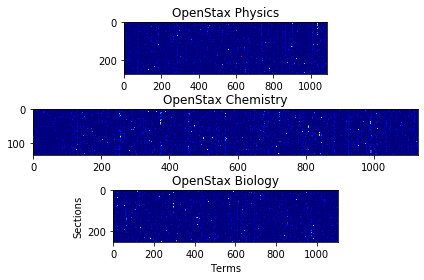

In [7]:
# Run TFIDF.
def run_tfidf (docs,verbose=1):
    # Calculate tfidf.

    # Term counter. Not used.
    #count = CountVectorizer()
    #count_matrix = count.fit_transform(docs)
    #np.savetxt('count.csv', count_matrix.toarray(), delimiter=',')

    tfidf = TfidfVectorizer(min_df=0.1,max_df=1.0)
    M = tfidf.fit_transform(docs).toarray()
    T = tfidf.get_feature_names() # terms, corresponding to tfidf.
    
    idx = np.argsort(-np.mean(M,axis=0)) # descending order.

    if (verbose): # Show top-N terms.
        print('=== Top terms ===================')
        str = ''
        for i in idx[:20]:
            #print('%20s:\t%.4f'%(T[i],np.mean(M[:,i])))
            str = str + '%s (%.3f), '%(T[i],np.mean(M[:,i]))
        print(str)
        str = ''
        print('=== Bottom terms ================')
        for i in idx[-10:]:
            #print('%20s:\t%.4f'%(T[i],np.mean(M[:,i])))
            str = str + '%s (%.3f), '%(T[i],np.mean(M[:,i]))
        print(str)

    if (0):
        plt.plot(M[:,idx].T)
        plt.xlabel('Term Index')
        plt.ylabel('TFIDF')
        plt.ylim((0,1))
        plt.tight_layout()
        plt.show()

    return M, T # Return sorted results

print('Run tfidf analysis for OS: PHYS, CHEM, BIOL')
M_OS_PHYS,T_OS_PHYS = run_tfidf(OS_PHYS)
M_OS_CHEM,T_OS_CHEM = run_tfidf(OS_CHEM)
M_OS_BIOL,T_OS_BIOL = run_tfidf(OS_BIOL)
#M_OS_ASTR,T_OS_ASTR = run_tfidf(OS_ASTR)

print('')

# Show the TFIDF matrix.
plt.subplot(3,1,1)
plt.imshow(M_OS_PHYS,interpolation='nearest',cmap='jet')
plt.title('OpenStax Physics')
plt.subplot(3,1,2)
plt.imshow(M_OS_CHEM,interpolation='nearest',cmap='jet')
plt.title('OpenStax Chemistry')
plt.subplot(3,1,3)
plt.imshow(M_OS_BIOL,interpolation='nearest',cmap='jet')
plt.title('OpenStax Biology')
#plt.subplot(4,1,4)
#plt.imshow(M_OS_ASTR,interpolation='nearest',cmap='jet')
#plt.title('OpenStax Astronomy')

plt.xlabel('Terms')
plt.ylabel('Sections')
plt.tight_layout()
plt.show()


In [8]:
# Create Venn Diagram of keywords from different corpus.
import matplotlib.colors as colors
#from matplotlib_venn_wordcloud import venn3_wordcloud
#from matplotlib_venn import venn3, venn2, venn3_circles

print('Run tfidf analysis for OS: PHYS, CHEM, BIOL')
M_OS_PHYS_unsorted,T_OS_PHYS_unsorted = run_tfidf(OS_PHYS,verbose=0)
M_OS_CHEM_unsorted,T_OS_CHEM_unsorted = run_tfidf(OS_CHEM,verbose=0)
M_OS_BIOL_unsorted,T_OS_BIOL_unsorted = run_tfidf(OS_BIOL,verbose=0)

def sort_tfidf (M,T):
    idx = np.argsort(-np.mean(M,axis=0)) # put things in descending order.
    M_sorted = M[:,idx]
    T_sorted = [T[i] for i in idx]
    return M_sorted, T_sorted

M_OS_PHYS,T_OS_PHYS = sort_tfidf(M_OS_PHYS_unsorted,T_OS_PHYS_unsorted)
M_OS_CHEM,T_OS_CHEM = sort_tfidf(M_OS_CHEM_unsorted,T_OS_CHEM_unsorted)
M_OS_BIOL,T_OS_BIOL = sort_tfidf(M_OS_BIOL_unsorted,T_OS_BIOL_unsorted)
  
topN = 100
print('\nTop terms from OS PHYS:')
print(*T_OS_PHYS[:topN],sep=', ')
print('\nTop terms from OS CHEM:')
print(*T_OS_CHEM[:topN],sep=', ')
print('\nTop terms from OS BIOL:')
print(*T_OS_BIOL[:topN],sep=', ')


P = set(T_OS_PHYS[:topN])
C = set(T_OS_CHEM[:topN])
B = set(T_OS_BIOL[:topN])
print("\nOverlapping terms:")
print(set.intersection(P,C,B))

# List various overlaps.
if 0:
    P = set(T_OS_PHYS[:topN])
    C = set(T_OS_CHEM[:topN])
    B = set(T_OS_BIOL[:topN])

    PCB = set.intersection(P,C,B)
    PC = set.intersection(P,C).difference(B)
    BC = set.intersection(B,C).difference(P)
    BP = set.intersection(P,B).difference(C)
    Ponly = P.difference(set.union(C,B))
    Conly = C.difference(set.union(P,B))
    Bonly = B.difference(set.union(P,C))

    print('\PCB')
    print(PCB)
    print('\nPonly')
    print(Ponly)
    print('\nConly')
    print(Conly)
    print('\nBonly')
    print(Bonly)
    print('\nPC (Physical Chemistry)')
    print(PC)
    print('\nBC (Biochemistry)')
    print(BC)
    print('\nBP (Biophysics)')
    print(BP)


Run tfidf analysis for OS: PHYS, CHEM, BIOL

Top terms from OS PHYS:
forc, energi, charg, wave, field, magnet, veloc, light, current, use, mass, motion, ray, object, electron, electr, two, direct, heat, one, point, temperatur, pressur, voltag, figur, momentum, acceler, time, particl, atom, speed, shown, water, imag, system, frequenc, show, resist, 10, radiat, vector, law, angl, wavelength, work, fluid, move, distanc, transfer, power, earth, sound, rotat, angular, chang, line, relat, calcul, produc, air, flow, posit, physic, circuit, kg, observ, exampl, equat, measur, given, nuclear, potenti, wire, surfac, zero, molecul, number, photon, differ, also, kinet, conserv, see, equal, valu, displac, 100, decay, first, find, part, right, length, small, exert, bodi, constant, reflect, per, weight

Top terms from OS CHEM:
atom, bond, reaction, label, electron, aq, energi, acid, figur, two, water, solut, molecul, ion, use, subscript, carbon, right, compound, metal, contain, mass, rate, form, struc

<Figure size 720x720 with 0 Axes>

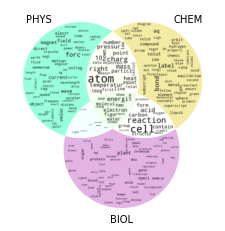

In [9]:
# Test wordcloud font size control
!pip install matplotlib_venn
!pip install matplotlib_venn_wordcloud

import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn2, venn3_circles
import matplotlib.colors as colors
from matplotlib_venn_wordcloud import venn3_wordcloud

# venn3_wordcloud: font size is random.
# plt.figure(figsize=(100,100))
# venn3_wordcloud([set(T_OS_PHYS[:topN]), set(T_OS_CHEM[:topN]), set(T_OS_BIOL[:topN])],
#     set_labels=['PHYS', 'CHEM', 'BIOL'],
#     set_colors=['aquamarine','khaki','plum'])
# plt.savefig('venn3_OS.png',dpi=600)
# plt.show()

# Create word_to_frequency dictionary, which will be used to 
# scale the font size within the word-cloud.
def get_max_value(Ms,Ts,t):
    # Find the maximum or mean value within M for given t.
    avgval = 0
    maxval = 0
    for i in range(len(Ts)):
        if t in Ts[i]:
            idx = Ts[i].index(t)
            this_val = np.mean(Ms[i],axis=0)[idx]
            if this_val>maxval:
                maxval = this_val
    return maxval

w2f = dict()
for t in set.union(P,C,B): 
    val = get_max_value((M_OS_PHYS,M_OS_CHEM,M_OS_BIOL),(T_OS_PHYS,T_OS_CHEM,T_OS_BIOL),t)
    w2f[t] = val**(1.5)

plt.figure(figsize=(10,10))
out = venn3_wordcloud([set(T_OS_PHYS[:topN]), set(T_OS_CHEM[:topN]), set(T_OS_BIOL[:topN])],
    set_labels=['PHYS', 'CHEM', 'BIOL'],
    set_colors=['aquamarine','khaki','plum'],
    set_edgecolors=[None,None,None],
    word_to_frequency=w2f)
for text in out.set_labels:
    text.set_fontsize(10)
plt.savefig('venn3_OS.png',dpi=600)
#plt.savefig('venn3_OS.eps',format='eps',dpi=1200)

plt.show()

In [10]:
# Sample code for saving/loading some data files.
import pickle
    
if 0:
    data = (M_OS_PHYS,T_OS_PHYS,OS_PHYS_titles)
    with open('OS_PHYS_M_T_title.p','wb') as f:
        pickle.dump(data, f)

if 0:
    with open('OS_PHYS_M_T_title.p','rb') as f:
        data = pickle.load(f)
    M = data[0]
    T = data[1]
    title = data[2]
    print(*title[:10],sep='\n')

Number of documents = 668
cell, energi, forc, atom, figur, use, plant, two, water, electron, one, molecul, reaction, organ, show, mass, system, speci, form, light, charg, bond, acid, protein, wave, veloc, temperatur, work, pressur, label, point, magnet, anim, field, bodi, dna, produc, gene, carbon, shown, heat, blood, structur, time, current, object, 10, chang, exampl, direct, particl, electr, call, differ, ion, ray, also, process, group, contain, right, motion, credit, human, solut, number, modif, imag, membran, mani, law, line, speed, relat, may, move, rate, air, equat, gas, increas, oxygen, calcul, arrow, part, compound, chemic, surfac, acceler, develop, left, earth, first, radiat, three, popul, food, result, subscript, frequenc


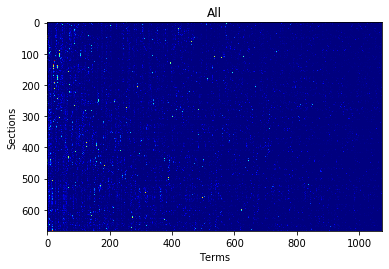

In [11]:
# Run tfidf for all corpus together.
FLAG_run_tfidf = True
if FLAG_run_tfidf:
    OS_all = OS_PHYS + OS_CHEM + OS_BIOL
    OS_titles = OS_PHYS_titles + OS_CHEM_titles + OS_BIOL_titles
    M_OS,T_OS = run_tfidf(OS_all,verbose=0)
    # Run tfidf and sort the terms, so that we have important vocab.
    M_OS,T_OS = sort_tfidf(M_OS,T_OS)

    with open('OS_M_T_titles.p','wb') as f:
        pickle.dump((M_OS,T_OS,OS_titles), f)
else:
    with open('OS_M_T_titles.p','rb') as f:
        data = pickle.load(f)
        M_OS = data[0]
        T_OS = data[1]
        OS_titles = data[2]
        
print('Number of documents = %d'%len(OS_titles))
print(*T_OS[:100],sep=', ')

plt.imshow(M_OS,interpolation='nearest',cmap='jet')
plt.title('All')
plt.xlabel('Terms')
plt.ylabel('Sections')
plt.show()

# Create a common vocabulary, and run tfidf.
#topN = 100
#vocab = np.sort(T_OS[:topN]) # Order alphabetically.

# Run tfidf on a fixed vocab.
# toarray() is not working.
#tfidf = TfidfVectorizer(min_df=0.1,max_df=1.0,vocabulary=vocab)
#M_P = tfidf.fit(OS_PHYS).toarray()
#M_C = tfidf.fit(OS_CHEM).toarray()
#M_B = tfidf.fit(OS_BIOL).toarray()

Titles of the first sections: PHYS, CHEM, BIOL
They all should be 1.0.
﻿1.0 Introduction to Science and the Realm of Physics, Physical Quantities, and Units
1.0 Essential Ideas
﻿1.0 The Study of Life


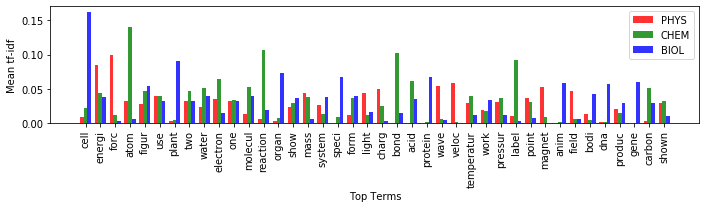

In [12]:
# Find ranges of PHYS, CHEM, BIOL corpus within the combined corpus.

corpus_len = (0,len(OS_PHYS_titles),len(OS_CHEM_titles),len(OS_BIOL_titles))
corpus_idx = np.array(corpus_len,dtype='int').cumsum()
PHYS_range = np.arange(corpus_idx[0],corpus_idx[1])
CHEM_range = np.arange(corpus_idx[1],corpus_idx[2])
BIOL_range = np.arange(corpus_idx[2],corpus_idx[3])
corpus_category = np.zeros(len(OS_titles))
corpus_category[PHYS_range] = 0
corpus_category[CHEM_range] = 1
corpus_category[BIOL_range] = 2

print('Titles of the first sections: PHYS, CHEM, BIOL')
print("They all should be 1.0.")
print(OS_titles[PHYS_range[0]])
print(OS_titles[CHEM_range[0]])
print(OS_titles[BIOL_range[0]])
#assert OS_titles[PHYS_range[0]].find("1.0 ")
#assert OS_titles[CHEM_range[0]].find("1.0 ")
#assert OS_titles[BIOL_range[0]].find("1.0 ")

# Find the importance of each term in each corpus.
# For example, how important is the term "energ" in PHYS, CHEM, or BIOL?
topN = 40
M_PHYS_avg = np.mean(M_OS[PHYS_range,:topN],axis=0)
M_CHEM_avg = np.mean(M_OS[CHEM_range,:topN],axis=0)
M_BIOL_avg = np.mean(M_OS[BIOL_range,:topN],axis=0)

plt.figure(figsize=(10,3))
index = np.arange(topN)
bar_width = 0.25
plt.bar(index-1*bar_width,M_PHYS_avg,bar_width,alpha=0.8,color='r',label='PHYS')
plt.bar(index+0*bar_width,M_CHEM_avg,bar_width,alpha=0.8,color='g',label='CHEM')
plt.bar(index+1*bar_width,M_BIOL_avg,bar_width,alpha=0.8,color='b',label='BIOL')

plt.xlabel('Top Terms')
plt.ylabel('Mean tf-idf')
plt.xticks(index, T_OS[:topN], rotation=90)
plt.legend(('PHYS','CHEM','BIOL'))
plt.tight_layout()
plt.savefig('top_terms.png',dpi=600)
#plt.savefig('top_terms.eps',format='eps',dpi=1200)
plt.show()

In [13]:
# Sample code for saving/loading some data files for fully combined corpus.
# Use the following data set for other codes.
import pickle

if 1:
    data = (M_OS,T_OS,OS_titles,corpus_category)
    with open('OS_all_M_T_title.p','wb') as f:
        pickle.dump(data, f)

if 0:
    with open('OS_all_M_T_title.p','rb') as f:
        data = pickle.load(f)
    M_OS = data[0]
    T_OS = data[1]
    OS_titles = data[2]
    corpus_category = data[3]
    assert len(corpus_category)==len(OS_titles)
    print(*OS_titles[:10],sep='\n')

In [14]:
# Look at the most correlated words within each corpus.

# Find index of a term.
def find_match_index (T,term,verbose=0):
    term = term.lower()
    term = stemmer.stem(term)
    indices = [i for i, s in enumerate(T) if term in s]
    if verbose:
        print('Search Term: %s'%(term))
    return(indices[0])

# Test find_match_index function.
#T[find_match_index(T,'Forced',verbose=1)]
#term = 'Forced'
#iPHYS = find_match_index(T_OS_PHYS,term)
#iCHEM = find_match_index(T_OS_CHEM,term)
#iBIOL = find_match_index(T_OS_BIOL,term)

def get_terms_with_large_corr (M,T,term,topN=10):
    i = find_match_index(T,term)
    cc_for_term = np.cov(M.T)[i,:] # or use np.corrcoef
    index_with_large_cc = np.argsort(-np.abs(cc_for_term))
    corr_terms = list()
    for k in range(topN):
        corr_terms.append(T[index_with_large_cc[k]])
    return corr_terms

topN = 8
print("What terms are correlated from each corpus?")
for i in range(10):
    term = T_OS[i]
    t_PHYS = get_terms_with_large_corr (M_OS[PHYS_range,:],T_OS,term,topN=topN)
    t_CHEM = get_terms_with_large_corr (M_OS[CHEM_range,:],T_OS,term,topN=topN)
    t_BIOL = get_terms_with_large_corr (M_OS[BIOL_range,:],T_OS,term,topN=topN)
    print('For the term: %s'%(term))
    print("PHYS: " + ", ".join(t_PHYS))
    print("CHEM: " + ", ".join(t_CHEM))
    print("BIOL: " + ", ".join(t_BIOL))
    print("")

print("Other curious examples")
term = "vector"
t_PHYS = get_terms_with_large_corr (M_OS[PHYS_range,:],T_OS,term,topN=topN)
t_CHEM = get_terms_with_large_corr (M_OS[CHEM_range,:],T_OS,term,topN=topN)
t_BIOL = get_terms_with_large_corr (M_OS[BIOL_range,:],T_OS,term,topN=topN)
print('For the term: %s'%(term))
print("PHYS: " + ", ".join(t_PHYS))
print("CHEM: " + ", ".join(t_CHEM))
print("BIOL: " + ", ".join(t_BIOL))
print("")


What terms are correlated from each corpus?
For the term: cell
PHYS: cell, membran, charg, resist, radiat, forc, cancer, molecul
CHEM: cell, potenti, label, bond, standard, half, atom, superscript
BIOL: cell, membran, speci, protein, popul, signal, plant, cycl

For the term: energi
PHYS: energi, kinet, conserv, work, potenti, magnet, radiat, electron
CHEM: energi, heat, acid, reaction, electron, ion, compound, atom
BIOL: energi, reaction, molecul, cell, gene, metabol, dna, chemic

For the term: forc
PHYS: forc, exert, wave, friction, ray, light, weight, vector
CHEM: liquid, forc, reaction, molecul, attract, tube, pressur, acid
BIOL: popul, cell, select, air, dna, water, volum, pressur

For the term: atom
PHYS: atom, electron, nucleus, molecul, forc, veloc, orbit, energi
CHEM: atom, bond, electron, reaction, structur, solut, pair, pressur
BIOL: atom, carbon, bond, molecul, electron, hydrogen, cell, element

For the term: figur
PHYS: rotat, figur, forc, direct, point, equilibrium, shown,

In [15]:
# Example analysis on OS.
examples = [100,200,300,400,500,600]
examples = [258,440,618,619,650]
examples = [258,440,618]

print('Consider the following examples')
[print (OS_titles[ex]) for ex in examples];

def show_top_terms (M,T,ex): 
    # Show the terms with the top TF-IDF values.
    howmany = 10
    idx = list()
    trm = list()
    for i in np.argsort(M[ex,:])[:-howmany:-1]:
        idx.append(i)
        trm.append(T[i])
    return idx, trm

# import matplotlib.cm as cm
# colors = cm.rainbow(np.linspace(0,1,40))
# Ndoc = len(titles)
# clist = list()
# chapter_numbers = list()
# for i in range(Ndoc):
#     title = OS_titles[i]
#     chapter_numbers.append(int(title.split('.')[0]))
#     clist.append(colors[chapter_numbers[i],:3])

for ex in examples: 
    print('\nProcessed text file (stem, stop-word removed) =====')
    print(OS_titles[ex])
    #print(OS_all[ex][:500])
    print('\nTop TFIDF vector')
    idx, trm = show_top_terms(M_OS,T_OS,ex)
    print(trm)

Consider the following examples
﻿32.3 Therapeutic Uses of Ionizing Radiation
﻿6.2 Potential, Kinetic, Free, and Activation Energy
﻿39.2 Gas Exchange across Respiratory Surfaces

Processed text file (stem, stop-word removed) =====
﻿32.3 Therapeutic Uses of Ionizing Radiation

Top TFIDF vector
['cancer', 'radiat', 'patient', 'tissu', 'ray', 'ratio', 'cell', 'normal', 'decay']

Processed text file (stem, stop-word removed) =====
﻿6.2 Potential, Kinetic, Free, and Activation Energy

Top TFIDF vector
['energi', 'reaction', 'chemic', 'free', 'releas', 'potenti', 'bond', 'activ', 'ball']

Processed text file (stem, stop-word removed) =====
﻿39.2 Gas Exchange across Respiratory Surfaces

Top TFIDF vector
['volum', 'pressur', 'air', 'mm', 'oxygen', 'partial', 'blood', 'gas', 'dioxid']


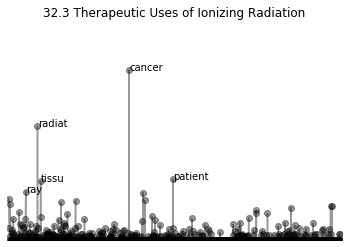

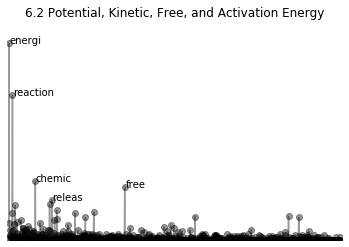

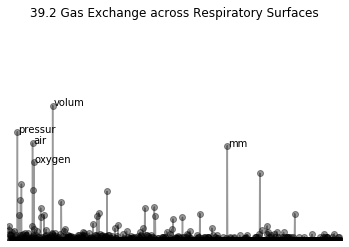

In [28]:
# Make a plot for a few examples.
# NOTE: here, we reduce the dimensionality of M_OS matrix.

topN = len(T_OS)
M_OS_topN = M_OS[:,:topN]
T_OS_topN = T_OS[:topN]

for ex in examples:
    plt.plot(M_OS_topN[ex,:],'ko-',alpha=0.4)
    idx, trm = show_top_terms(M_OS_topN,T_OS_topN,ex)
    for i in range(5):
        plt.text(idx[i]+2,M_OS_topN[ex,idx[i]],trm[i])
    plt.gca().axison=False
    plt.xlabel('Terms')
    plt.ylabel('TFIDF')
    #plt.ylabel(OS_titles[ex])
    plt.ylim((0,0.75))
    plt.xlim((-5,len(T_OS_topN)+5))
    #plt.title(OS_titles[ex]) # Some titles are too long because of subtitles.
    plt.title(OS_titles[ex].split(':')[0])
    plt.xticks(())
    plt.yticks(())
    plt.savefig('featvec_ex%d'%ex,dpi=600)
    #plt.savefig('featvec_ex%d'%ex+'.eps',format='eps',dpi=1200)
    plt.show()


In [17]:
print('Number of files = %d'%M_OS.shape[0])        
print('Number of terms = %d'%M_OS.shape[1])        

Number of files = 668
Number of terms = 1073


## PCA visualization

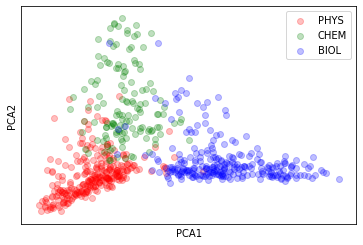

In [18]:
# Work on OpenStax only.
from sklearn.decomposition import PCA

corpus_len = (0,len(OS_PHYS_titles),len(OS_CHEM_titles),len(OS_BIOL_titles))
corpus_idx = np.array(corpus_len).cumsum()
PHYS_range = range(corpus_idx[0],corpus_idx[1])
CHEM_range = range(corpus_idx[1],corpus_idx[2])
BIOL_range = range(corpus_idx[2],corpus_idx[3])

c = ('red','green','blue')

data = M_OS
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data)
x = reduced_data[:,0]
y = reduced_data[:,1]
#plt.scatter(x,y,alpha=0.25)
plt.scatter(x[PHYS_range],y[PHYS_range],alpha=0.25,color=c[0])
plt.scatter(x[CHEM_range],y[CHEM_range],alpha=0.25,color=c[1])
plt.scatter(x[BIOL_range],y[BIOL_range],alpha=0.25,color=c[2])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xticks(())
plt.yticks(())
plt.legend(('PHYS','CHEM','BIOL'))

plt.savefig('scatter.png',dpi=600)
#plt.savefig('scatter.eps',format='eps',dpi=1200)
plt.show()

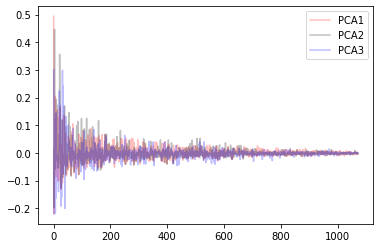

PCA 0
index =   0: val = +0.4942, term = cell
index =   2: val = -0.2205, term = forc
index =   6: val = +0.2052, term = plant
index =  23: val = +0.1656, term = protein
index =  13: val = +0.1553, term = organ
index =   1: val = -0.1501, term = energi
index =  37: val = +0.1364, term = gene
index =  35: val = +0.1339, term = dna
index =  25: val = -0.1312, term = veloc
index =  17: val = +0.1274, term = speci

PCA 1
index =   3: val = +0.4468, term = atom
index =  21: val = +0.3566, term = bond
index =  22: val = +0.2019, term = acid
index =   2: val = -0.1979, term = forc
index =   9: val = +0.1939, term = electron
index =  12: val = +0.1735, term = reaction
index =  38: val = +0.1701, term = carbon
index =  11: val = +0.1634, term = molecul
index =  54: val = +0.1457, term = ion
index =  25: val = -0.1274, term = veloc

PCA 2
index =   0: val = +0.3013, term = cell
index =  31: val = +0.2989, term = magnet
index =  33: val = +0.2428, term = field
index =  20: val = +0.2242, term = c

In [19]:
plt.plot(pca.components_[0,:],'r-',alpha=0.25)
plt.plot(pca.components_[1,:],'k-',alpha=0.25)
plt.plot(pca.components_[2,:],'b-',alpha=0.25)
plt.legend(('PCA1','PCA2','PCA3'))
plt.show()

topN = 10
for pca_num in range(3):
    pcavec = pca.components_[pca_num,:]
    print('PCA %d'%pca_num)
    for i in np.argsort(-np.abs(pcavec))[:topN]:
        print('index = %3d: val = %+.4f, term = %s'%(i,pcavec[i],T_OS[i]))
    print('')


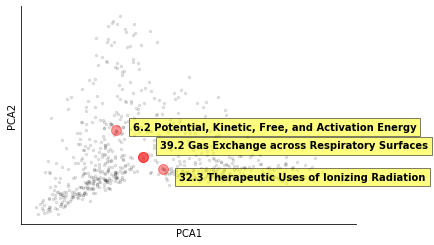

In [20]:
# Do a PCA plot of a few examples.
ax = plt.subplot(111)
ax.plot(x,y,'k.', markersize=5, alpha=0.1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

for i in examples:
    plt.plot(x[i],y[i],'r.',markersize=20,alpha=0.4)
    #plt.text(x[i]+0.02,y[i],OS_titles[i].split(':')[0])
# For 3 example case, hard-code the separation in titles.
bbox=dict(facecolor='red', alpha=0.9)
plt.text(x[examples[0]]+0.05,y[examples[0]]-0.05,OS_titles[examples[0]].split(':')[0],fontweight='bold',bbox=dict(facecolor='yellow', alpha=0.5))
plt.text(x[examples[1]]+0.05,y[examples[1]]+0.00,OS_titles[examples[1]].split(':')[0],fontweight='bold',bbox=dict(facecolor='yellow', alpha=0.5))
plt.text(x[examples[2]]+0.05,y[examples[2]]+0.04,OS_titles[examples[2]].split(':')[0],fontweight='bold',bbox=dict(facecolor='yellow', alpha=0.5))

plt.plot(x[i],y[i],'r.',markersize=20,alpha=0.4)

plt.xticks(())
plt.yticks(())
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.savefig('scatter_ex.png',dpi=600)
#plt.savefig('scatter_ex.eps',format='eps',dpi=1200)

plt.show()

In [21]:
# Make an interactive bokeh plot.

from bokeh.plotting import figure, show
from bokeh.io import output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import viridis, inferno

output_notebook()
output_file("pca_2d_OS.html")
# Create a colormap and assign color to each chapter.
#Nchapters = len(set(chapter_numbers)) # Number of unique chapters.
#cm = viridis(Nchapters)
#cm = inferno(Nchapters)
#for chapter in chapter_numbers:
#    bokeh_clist.append(cm[chapter-1])

# Assign colors.
Nsections = len(x)
bokeh_clist = list()
for i in range(Nsections):
    if i in PHYS_range:
        bokeh_clist.append('red')
    if i in CHEM_range:
        bokeh_clist.append('green')
    if i in BIOL_range:
        bokeh_clist.append('blue')

source = ColumnDataSource (
    data = dict(x=x,
                y=y,
                titles=OS_titles,bokeh_clist=bokeh_clist))

p = figure(plot_width=400, plot_height=400, title="PCA")
p.xaxis.axis_label = 'PCA1'
p.yaxis.axis_label = 'PCA2'
p.axis.axis_line_color = None

p.add_tools( HoverTool(
    tooltips=[( '', '@titles' )],
    # display a tooltip whenever the cursor is 
    # vertically in line with a glyph
    #mode='vline'
))
p.circle(x='x',y='y',fill_color='bokeh_clist',
         size=10,alpha=0.5,line_color=None,source=source)

show(p)

Loading BokehJS ...

As shown in the above figure, where each section is repersented as a point using PCA with colors corresponding to individual chapter numbers, the sections in the same chapter are clustered together. 

## t-SNE
Let's try to discover the relationship between sections and corpus, using t-SNE.

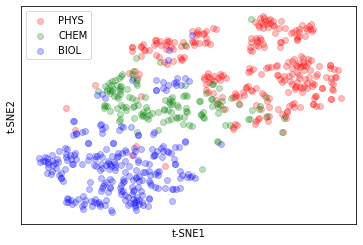

More relationship between PHYS and CHEM.
Explore those sections that are mingling with other sections.
Note: tSNE is stochastic.


In [22]:
# tSNE method.

from sklearn.manifold import TSNE

data = M_OS
tsne = TSNE(n_components=2).fit_transform(data)
x = tsne[:,0]
y = tsne[:,1]
#plt.scatter(x,y,alpha=0.25)
plt.scatter(x[PHYS_range],y[PHYS_range],alpha=0.25,color=c[0])
plt.scatter(x[CHEM_range],y[CHEM_range],alpha=0.25,color=c[1])
plt.scatter(x[BIOL_range],y[BIOL_range],alpha=0.25,color=c[2])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.xticks(())
plt.yticks(())
plt.legend(('PHYS','CHEM','BIOL'))
plt.savefig('scatter_tSNE.png',dpi=600)
#plt.savefig('scatter_tSNE.eps',format='eps',dpi=1200)
plt.show()

print("More relationship between PHYS and CHEM.")
print("Explore those sections that are mingling with other sections.")
print("Note: tSNE is stochastic.")

## Neighborhood
Calculate neighborhood.

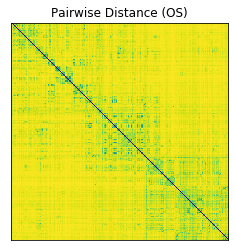

4.2 Classifying Chemical Reactions
17.1 Review of Redox Chemistry
18.9 Occurrence, Preparation, and Compounds of Oxygen
18.11 Occurrence, Preparation, and Properties of Halogens
4.1 Writing and Balancing Chemical Equations
18.5 Occurrence, Preparation, and Compounds of Hydrogen
14.1 Brønsted-Lowry Acids and Bases
15.3 Coupled Equilibria
18.3 Structure and General Properties of the Metalloids
14.4 Hydrolysis of Salts


In [23]:
def find_pdist (M):
    # M is number of points (row) x dimensions (column)
    pdist = np.sqrt(np.sum((M[None, :] - M[:, None])**2, -1))
    return pdist

# Calculate pairwise distances.
pdist_OS = find_pdist(M_OS)
pdist_OS = pdist_OS/np.max(pdist_OS)

plt.figure(figsize=(4,4))
plt.imshow(pdist_OS)
plt.title('Pairwise Distance (OS)')
plt.xticks(())
plt.yticks(())
plt.savefig('pdist_OS.png')
#plt.savefig('pdist_OS.eps',format='eps',dpi=1200)
plt.show()

def get_triu (m):
    # From a square matrix, m, take the upper-right corner values.
    (d,tmp) = m.shape
    assert d==tmp
    m_triu = np.zeros((int(d*(d-1)/2),1))
    k = 0
    for i in range(d):
        for j in range(i+1,d):
            m_triu[k] = m[i,j]
            k = k+1
    return m_triu

def get_neighbors (titles,pdist,ex,topN=10):
    pairdist = pdist[ex,:]
    idx = np.argsort(pairdist)
    neighbors = list()
    for i in range(topN):
        neighbors.append(titles[idx[i]])
    return neighbors

def get_neighbors_chapters (nbor,topN=10,verbose=True):
    # The first in the list is itself.
    title_split = '.'
    topN = len(nbor)
    ch_list = list()
    for i in range(topN):
        ch_list.append(nbor[i].split(title_split)[0])
        if verbose: print(nbor[i])
    return np.array(ch_list,dtype='int')

nbor = get_neighbors(OS_titles,pdist_OS,300)
ch_list = get_neighbors_chapters(nbor,topN=5)

In [24]:
# Make an interactive bokeh plot.
# Show the neighborhood info.

# Set up nearest neighbor info.
nbor0 = list()
nbor1 = list()
nbor2 = list()
nbor3 = list()
nbor4 = list()
for i in range(len(OS_titles)):
    nbor = get_neighbors(OS_titles,pdist_OS,i)
    nbor0.append(nbor[0])
    nbor1.append(nbor[1])
    nbor2.append(nbor[2])
    nbor3.append(nbor[3])
    nbor4.append(nbor[4])

x = reduced_data[:,0]
y = reduced_data[:,1]

from bokeh.plotting import figure, show
from bokeh.io import output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import viridis, inferno

output_notebook()
output_file("pca_2d_OS_related.html")

# Create a colormap and assign color to each chapter.
# Nchapters = len(set(chapter_numbers)) # Number of unique chapters.
# cm = viridis(Nchapters)
# cm = inferno(Nchapters)
# bokeh_clist = list()
# for chapter in chapter_numbers:
#     bokeh_clist.append(cm[chapter-1])

source = ColumnDataSource (
    data = dict(x=x,
                y=y,
                titles=OS_titles,
                n0=nbor0,
                n1=nbor1,
                n2=nbor2,
                n3=nbor3,
                bokeh_clist=bokeh_clist))

p = figure(plot_width=900, plot_height=900, title="OpenStax (red: PHYS, green: CHEM, blue: BIOL)")
p.xaxis.axis_label = 'PCA1'
p.yaxis.axis_label = 'PCA2'
p.axis.axis_line_color = None

p.add_tools( HoverTool(
    tooltips=[
        ( 'Title', '@titles' ),
        #( 'Related 0', '@n0'), # Same as the title.
        ( 'Related 1', '@n1'),
        ( 'Related 2', '@n2'),
        ( 'Related 3', '@n3'),
    ],
    # display a tooltip whenever the cursor is 
    # vertically in line with a glyph
    #mode='vline'
))
p.circle(x='x',y='y',fill_color='bokeh_clist',
         size=10,alpha=0.5,line_color=None,source=source)

show(p)

Loading BokehJS ...

In [25]:
# Find index of a term.
import re

def find_match_index (T,term,verbose=0):
    term = term.lower()
    indices = list()
    for i, s in enumerate(T):
        if s==term:
            indices.append(i)
    if verbose:
        print('Search Term: %s'%(term))
    return(indices)

find_match_index(T_OS,'cell',verbose=1)

Search Term: cell


[0]

In [26]:
# Study target.
def make_target_vector_from_terms (T,study_target):
    target_vec = np.zeros(len(T_OS))
    for t in study_target:
        idx = find_match_index(T_OS,t)
        if len(idx)==1:
            target_vec[idx[0]]=1.0
        else:
            print("term %s was not found."%(t))
    return target_vec

def get_titles_matching_target (M,target,titles,topN=10):
    # Calculate normalized dot-product as a way of distance to the target.
    # Other scoring (i.e., distance) measures are possible.
    target_normed = target/np.linalg.norm(target)
    score = np.dot([i/np.linalg.norm(i) for i in M],target_normed)

    sort_idx = np.argsort(-score)    
    selected_titles = list()
    for i in sort_idx[:topN]:
        selected_titles.append(titles[i])
    return selected_titles

term_list = list(('cell','vector'))
target_vec = make_target_vector_from_terms(T_OS,term_list)
selected_titles = get_titles_matching_target(M_OS,target_vec,OS_titles,topN=10)
print(term_list)
print("\n".join(selected_titles))
print("")

term_list = list(('motion','forc'))
target_vec = make_target_vector_from_terms(T_OS,term_list)
selected_titles = get_titles_matching_target(M_OS,target_vec,OS_titles,topN=10)
print(term_list)
print("\n".join(selected_titles))
print("")

term_list = list(('forc','energi'))
target_vec = make_target_vector_from_terms(T_OS,term_list)
selected_titles = get_titles_matching_target(M_OS,target_vec,OS_titles,topN=10)
print(term_list)
print("\n".join(selected_titles))
print("")


['cell', 'vector']
﻿3.2 Vector Addition and Subtraction: Graphical Methods
﻿42.2 Adaptive Immune Response
﻿3.3 Vector Addition and Subtraction: Analytical Methods
﻿4.0 Cell Structure
﻿42.1 Innate Immune Response
﻿10.0 Cell Reproduction 
﻿4.2 Prokaryotic Cells
﻿4.6 Connections between Cells and Cellular Activities
﻿10.5 Prokaryotic Cell Division
﻿10.2 The Cell Cycle

['motion', 'forc']
﻿2.0 Introduction to One-Dimensional Kinematics
﻿6.0 Introduction to Uniform Circular Motion and Gravitation
﻿4.8 Extended Topic: The Four Basic Forces—An Introduction
﻿5.0 Introduction: Further Applications of Newton’s Laws
﻿4.1 Development of Force Concept
﻿4.4 Newton’s Third Law of Motion: Symmetry in Forces
﻿9.5 Simple Machines
﻿4.3 Newton’s Second Law of Motion: Concept of a System
﻿16.1 Hooke's Law: Stress and Strain Revisited
﻿4.6 Problem-Solving Strategies

['forc', 'energi']
﻿7.4 Conservative Forces and Potential Energy
﻿7.6 Conservation of Energy
﻿7.5 Nonconservative Forces
﻿7.2 Kinetic Energy a

### Discovering multidisciplinary topics.

The pairwise distance between documents can be used to examine the neighborhood of a given document and the level of interdisciplinarity.  A document that is close to other documents from different disciplines can be regarded as containing a highly interdisciplinary topic.  For example, the neighborhood of the following documents contains other documents from biology, chemistry, and physics.  More specifically, each of these documents had at least 2 documents from each of 3 textbooks among its 13 closest neighbors.  Other selection criteria of different neighborhood sizes produced similar results.


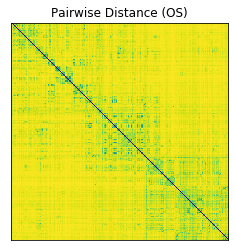

ID  90: ﻿12.7 Molecular Transport Phenomena: Diffusion, Osmosis, and Related Processes
PHYS: ﻿12.7 Molecular Transport Phenomena: Diffusion, Osmosis, and Related Processes
BIOL: ﻿5.2 Passive Transport
BIOL: ﻿39.1 Systems of Gas Exchange
BIOL: ﻿41.1 Osmoregulation and Osmotic Balance
CHEM: 9.4 Effusion and Diffusion of Gases
BIOL: ﻿5.4 Bulk Transport
PHYS: ﻿20.7 Nerve Conduction - Electrocardiograms
BIOL: ﻿5.1 Components and Structure
BIOL: ﻿2.2 Water
BIOL: ﻿30.5 Transport of Water and Solutes in Plants
CHEM: 11.4 Colligative Properties
BIOL: ﻿41.2 The Kidneys and Osmoregulatory Organs
PHYS: ﻿13.6 Humidity, Evaporation, and Boiling
CHEM: 11.3 Solubility

ID 258: ﻿32.3 Therapeutic Uses of Ionizing Radiation
PHYS: ﻿32.3 Therapeutic Uses of Ionizing Radiation
PHYS: ﻿32.2 Biological Effects of Ionizing Radiation
CHEM: 21.6 Biological Effects of Radiation
PHYS: ﻿31.1 Nuclear Radioactivity
BIOL: ﻿16.7 Cancer and Gene Regulation
PHYS: ﻿32.1 Medical Imaging and Diagnostics
CHEM: 21.5 Uses of Ra

In [27]:
# Calculate pair-wise distance.
#pdist_OS = squareform(pdist(M_OS))

pdist_OS = find_pdist(M_OS)
pdist_OS = pdist_OS/np.max(pdist_OS)

plt.figure(figsize=(4,4))
plt.imshow(pdist_OS)
plt.title('Pairwise Distance (OS)')
plt.xticks(())
plt.yticks(())
plt.savefig('pdist_OS.png')
#plt.savefig('pdist_OS.eps',format='eps',dpi=1200)
plt.show()

# Go through each section, and find topN neighbors.
# Check if the neighbors are from all 3 categories.
# Print out the interdisciplinary chapters.
cat = ["PHYS","CHEM","BIOL"]

topN = 14
thresh = 2

for ex in range(len(corpus_category)):
    pairdist = pdist_OS[ex,:]
    idx = np.argsort(pairdist)
    neighbor_category = list()
    for i in range(topN):
        #print(OS_titles[idx[i]])
        neighbor_category.append(int(corpus_category[idx[i]]))
    # This condition checks whether topN contains all 3 categories.
    # This result is not so interesting, so commented out.
    # Use topN = 3.
    #if len(set(neighbor_category))==3:
    
    # This condition checks whether topN contains reasonble number of
    # other topics.  (topN=14, thresh=2 for example).
    # The result is more interesting.
    if (neighbor_category.count(0)>thresh) & (neighbor_category.count(1)>thresh) & (neighbor_category.count(2)>thresh):
        print ("ID %3d: %s"%(ex,OS_titles[ex]))
        for i in range(topN):
            print("%s: %s"%(cat[neighbor_category[i]],OS_titles[idx[i]]))
        print('')
